# Statistiques sur les données

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

data = pd.read_csv("scrapping_script/donnees_labelisees_3600.csv")

In [2]:
import random
from torch.utils.data import Dataset, DataLoader

class AugmentedTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len, blacklist_words=None, remove_random=False, remove_prob=0.4, shuffle_prob=0.1,
                 train=True):
        """
        Dataset personnalisé pour appliquer des augmentations de texte dynamiques.
        
        Args:
            texts (list of str): Textes bruts.
            labels (list of int): Labels correspondants.
            tokenizer: Tokeniseur (par ex. de transformers).
            max_len (int): Longueur maximale des séquences.
            blacklist_words (list of str): Liste noire de mots à supprimer.
            remove_random (bool): Si True, supprime des mots au hasard.
            remove_prob (float): Fraction de mots à supprimer aléatoirement.
            shuffle_prob (float): Probabilité de mélanger les mots.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.blacklist_words = blacklist_words or []
        self.remove_random = remove_random
        self.remove_prob = remove_prob
        self.shuffle_prob = shuffle_prob
        self.train = train

    def __len__(self):
        return len(self.texts)

    def augment_text(self, text):
        """
        Applique des transformations aléatoires sur un texte.
        """
        if self.train:
            words = text.split()

            # Supprimer les mots de la liste noire
            words = [word for word in words if word.lower() not in self.blacklist_words]

            # Supprimer des mots aléatoirement
            if self.remove_random:
                num_to_remove = int(len(words) * self.remove_prob)
                words = [word for i, word in enumerate(words) if i not in random.sample(range(len(words)), num_to_remove)]

            # Mélanger les mots aléatoirement
            if random.random() < self.shuffle_prob:
                random.shuffle(words)

            return ' '.join(words)
        else:
            return text

    def __getitem__(self, idx):
        """
        Récupère un échantillon transformé et tokenisé.
        """
        text = self.texts[idx]
        label = self.labels[idx]

        # Appliquer des augmentations aléatoires
        augmented_text = self.augment_text(text)

        # Tokenisation
        encoding = self.tokenizer(
            augmented_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt',
        )

        input_ids = encoding['input_ids'].squeeze(0)  # Enlever la dimension batch
        attention_mask = encoding['attention_mask'].squeeze(0)

        return input_ids, attention_mask, label



In [3]:
# Fonction pour attribuer des couleurs aux labels
def color_labels(label):
    colors = {
        "culture": '#1f77b4',        # Bleu clair
        "monde": '#ff7f0e',         # Orange
        "meteo": '#2ca02c',         # Vert
        "sante": '#d62728',         # Rouge
        "politique": '#9467bd',     # Violet
        "societe": '#8c564b',       # Marron
        "europe": '#e377c2',        # Rose
        "environnement": '#7f7f7f', # Gris
        "sports": '#bcbd22'         # Jaune
    }
    return f'<span style="color: {colors.get(label, "black")};">{label}</span>'

# Itérer sur les labels uniques
html_tables = []  # Stocker les tableaux HTML pour les afficher ou les exporter
for label in data['Label'].unique():
    # Filtrer les données pour le label courant et prendre un échantillon
    df = data[data['Label'] == label].sample(10, random_state=42)  # Fixer un état aléatoire pour reproductibilité

    # Ajouter des couleurs aux labels
    df['styled_label'] = df['Label'].apply(color_labels)

    # Création d'un tableau HTML stylisé
    html_table = df[['Titre', 'styled_label']].rename(columns={'Titre': 'Title', 'styled_label': 'Label'}).to_html(escape=False, index=False)

    # Ajouter à la liste des tableaux
    html_tables.append(f"<h3>{label.capitalize()} Articles</h3>" + html_table)

# Afficher tous les tableaux HTML
from IPython.core.display import display, HTML
display(HTML("<br><br>".join(html_tables)))


/tmp/ipykernel_17450/1618431501.py:32: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Title,Label
Goscinny,culture
Jeux Vidéo,culture
Street Art,culture
Le rappeur américain Young Thug libéré après avoir reconnu son implication dans un gang,culture
"Netflix, Disney+ et Prime Video ont versé 362 millions d'euros pour la création française en 2023",culture
"Quand les Normands apprenaient à nager au XIXe siècle : à Paluel, l'exposition ""Les pieds dans l'eau"" raconte l'histoire en caricatures",culture
Michael Jackson,culture
"Jeux vidéo : le smartphone, première console des Français",culture
Brigitte Bardot,culture
Rock,culture


In [4]:
from transformers import CamembertTokenizer, CamembertForSequenceClassification

model_name = 'camembert-base'
tokenizer = CamembertTokenizer.from_pretrained(model_name)
model = CamembertForSequenceClassification.from_pretrained(model_name, num_labels=9)

max_len = 128
encodings = tokenizer(data['Titre'].astype(str).tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='pt')


/home/gris/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 11:28:59.112227: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-06 11:28:59.122367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733480939.135705   17450 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733480939.139695   17450 cuda_blas.cc:1418] Unable t

In [5]:
old_data = AugmentedTextDataset(
    texts=data['Titre'],
    labels=data['Label'],
    tokenizer=tokenizer,
    max_len=max_len,
    blacklist_words=None,  
    remove_random=False,
    remove_prob=0,
    shuffle_prob=0,
    train=False
)

In [14]:
#Exemple de token:
# Récupération des données
token_data = old_data.__getitem__(1027)[0]
text_data = old_data.texts[1027]

# Affichage stylisé
print("=== Détail de l'Élément 1024 ===")
print("\nTokens:")
print(token_data)
print("\nTitre Original:")
print(text_data)


=== Détail de l'Élément 1024 ===

Tokens:
tensor([    5, 12950, 10422,   219, 10299,    22, 25240,    43,    17,    11,
         4244, 13110,    13,  1986,    25,  1100,   909,    26,    81,  7257,
            6,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1, 

In [7]:
stat = pd.DataFrame(columns=['Taille_token', 'Label'])

for i in range(data.shape[0]):
    val = old_data.__getitem__(i)[1:] 
    taille_token = val[0].sum().item()        
    label = val[1]                     

    stat.loc[i + 1] = [taille_token, label]

print(stat)


      Taille_token    Label
1                3  culture
2               34  culture
3                5  culture
4               25  culture
5                4  culture
...            ...      ...
3597             8   sports
3598            32   sports
3599             9   sports
3600            27   sports
3601             7   sports

[3601 rows x 2 columns]


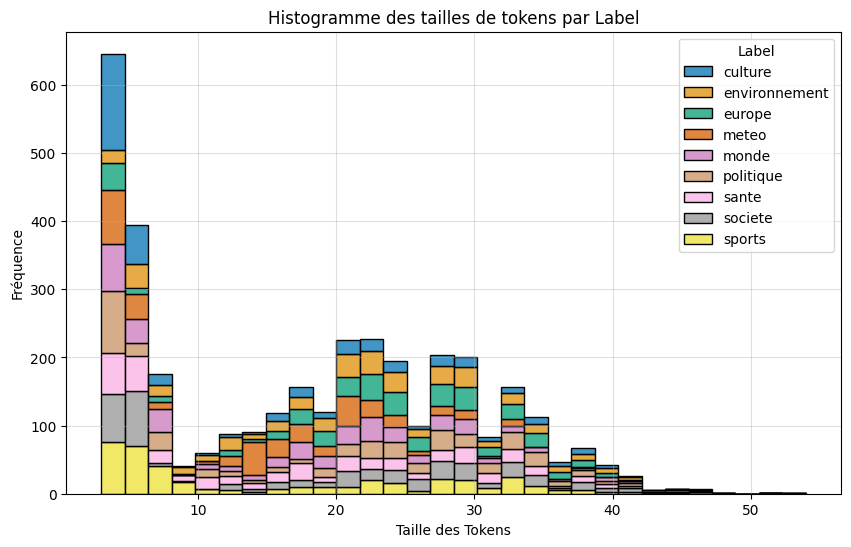

In [8]:
import seaborn as sns

# Créer l'histogramme avec Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=stat, x='Taille_token', hue='Label', multiple='stack', bins=30, palette='colorblind')

# Ajouter des détails
plt.xlabel('Taille des Tokens')
plt.ylabel('Fréquence')
plt.title('Histogramme des tailles de tokens par Label')
plt.grid(alpha=0.4)
plt.show()
